In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import Tuple



In [2]:

non_pair_helix_dir = "/home/wzarzecki/ds_10000x_normalized/coefs/non_pair_helix_no_timestep"
non_pair_beta_dir = "/home/wzarzecki/ds_10000x_normalized/coefs/non_pair_beta_no_timestep"
coefs_filename = "coef.npy"
bias_filename = "bias.npy"

In [3]:
helix_coefs = torch.from_numpy(np.load(os.path.join(non_pair_helix_dir, coefs_filename))[0])
beta_ceofs = torch.from_numpy(np.load(os.path.join(non_pair_beta_dir, coefs_filename))[0])
diff_ceofs = helix_coefs - beta_ceofs
diff_ceofs.shape

torch.Size([4736])

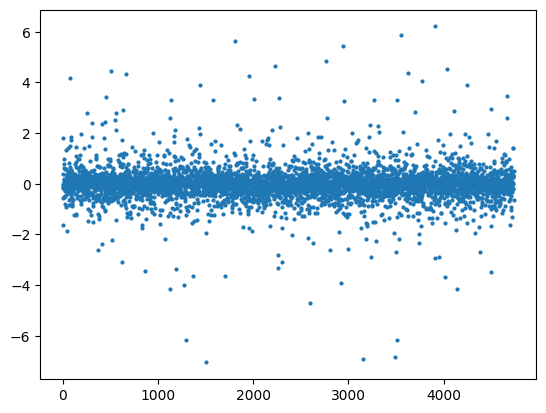

In [4]:
plt.scatter(list(range(len(diff_ceofs))), diff_ceofs, s=4)
plt.show()

In [13]:
def read_npy_coefs_to_torch(path_to_npy_file: str) -> torch.Tensor:
    return torch.from_numpy(np.load(path_to_npy_file)[0])

coef_helix = "/home/wzarzecki/ds_10000x_normalized/coefs/non_pair_helix_no_timestep/coef.npy"
coef_beta = "/home/wzarzecki/ds_10000x_normalized/coefs/non_pair_beta_no_timestep/coef.npy"

helix = read_npy_coefs_to_torch(coef_helix)
beta = read_npy_coefs_to_torch(coef_beta)


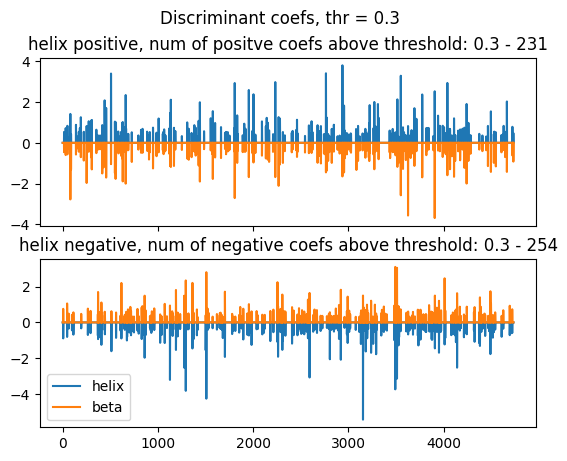

In [14]:
threshold = 0.3

def get_big_coefs_mask(helix: torch.Tensor, beta: torch.Tensor, threshold: float) -> Tuple[torch.Tensor, torch.Tensor]:
    """positive mean positively correlated with first class"""
    positive_indices = torch.logical_and(helix > threshold, beta < -threshold)
    negative_indices = torch.logical_and(helix < -threshold, beta > threshold)
    return positive_indices, negative_indices

positive_coefs_mask, negative_coefs_mask = get_big_coefs_mask(helix, beta, threshold)
masked_helix_pos = helix.clone()
masked_helix_pos[~positive_coefs_mask] = 0
masked_beta_pos = beta.clone()
masked_beta_pos[~positive_coefs_mask] = 0

masked_helix_neg = helix.clone()
masked_helix_neg[~negative_coefs_mask] = 0
masked_beta_neg = beta.clone()
masked_beta_neg[~negative_coefs_mask] = 0


positive_count = len(torch.nonzero(positive_coefs_mask))
negative_count = len(torch.nonzero(negative_coefs_mask))
total_count = positive_count + negative_count

fig, ax = plt.subplots(2, 1)
ax[0].plot(list(range(len(masked_helix_pos))), masked_helix_pos, label="helix")
ax[0].plot(list(range(len(masked_beta_pos))), masked_beta_pos, label="beta")
ax[0].set_title(f"helix positive, num of positve coefs above threshold: {threshold} - {positive_count}")
ax[0].xaxis.set_ticklabels([])

ax[1].plot(list(range(len(masked_helix_pos))), masked_helix_neg, label="helix")
ax[1].plot(list(range(len(masked_beta_pos))), masked_beta_neg, label="beta")
ax[1].set_title(f"helix negative, num of negative coefs above threshold: {threshold} - {negative_count}")

fig.suptitle(f"Discriminant coefs, thr = {threshold}")
plt.legend()
plt.show()


In [17]:
thresholds = [0.5 + 0.5 * x for x in range(7)]
thresholds


[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]

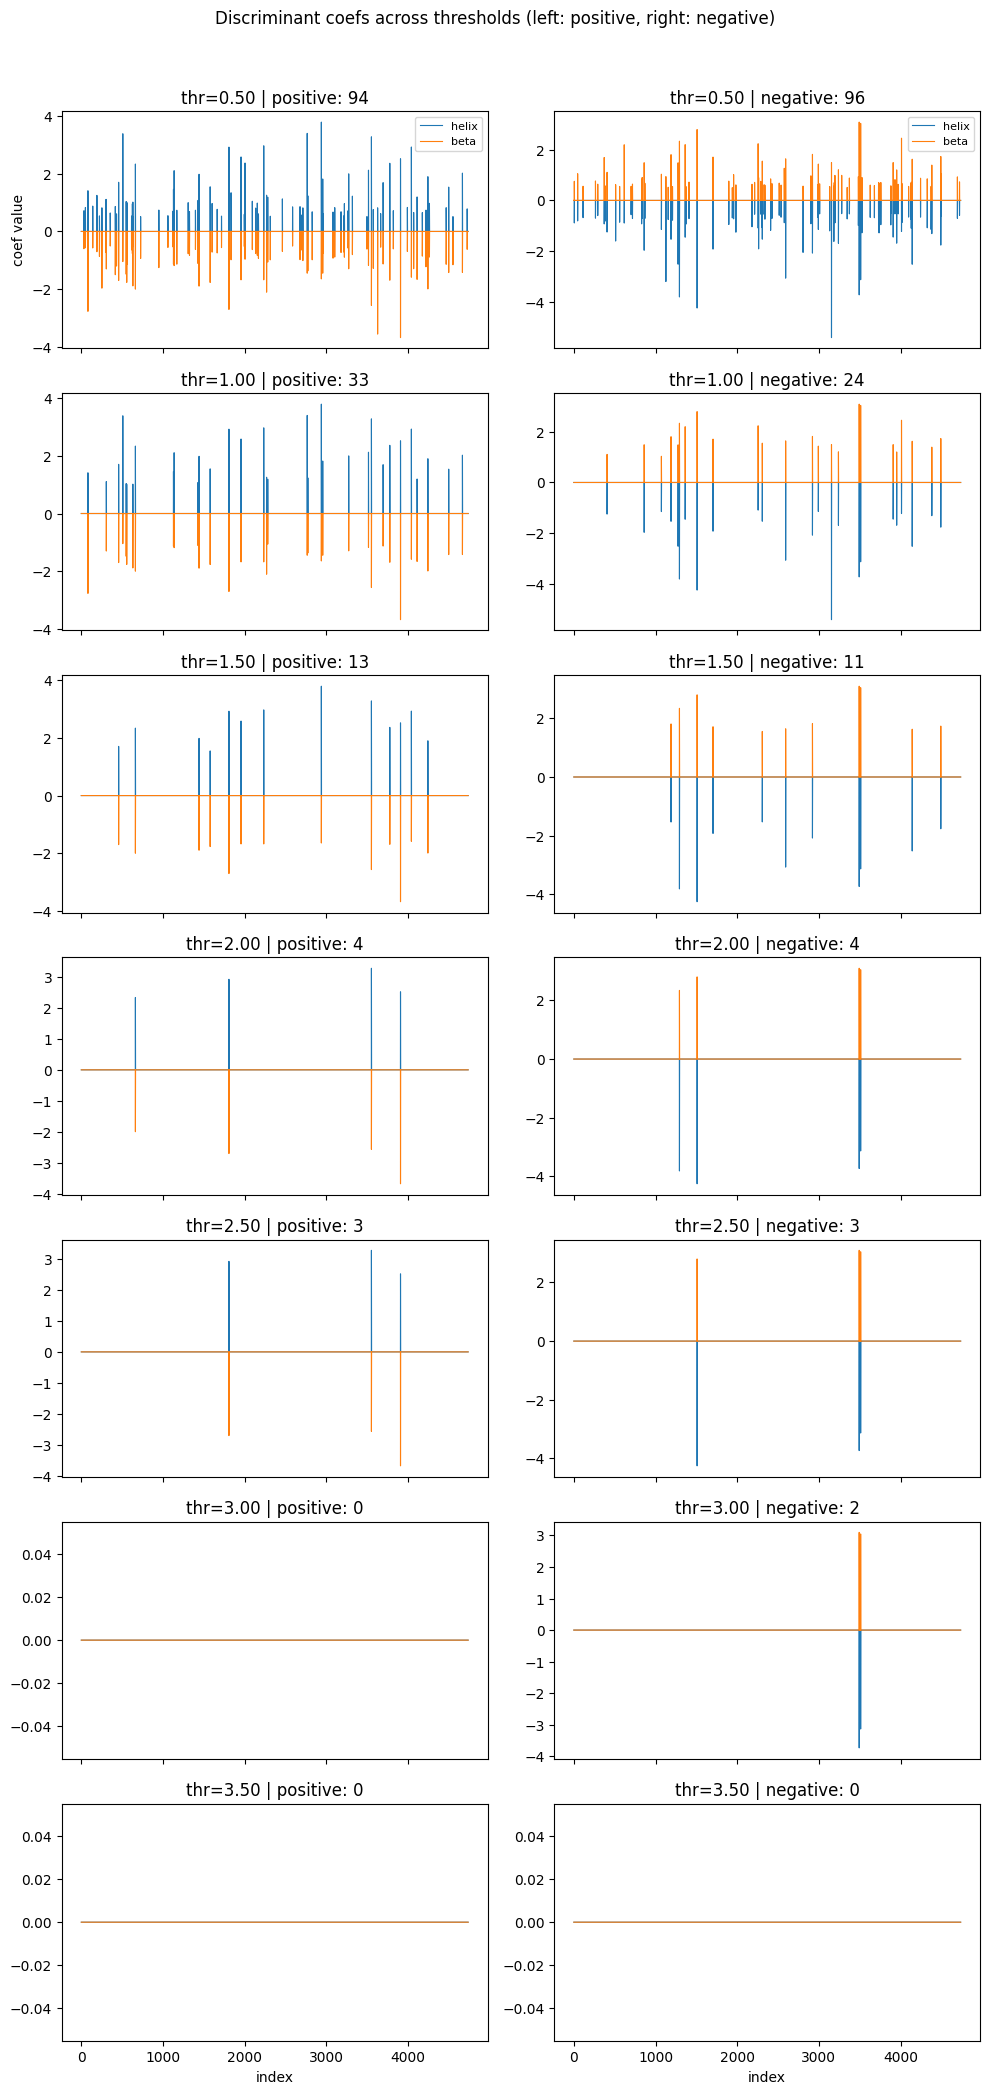

In [18]:
# Plot for each threshold in a single figure with many subplots
num_thresholds = len(thresholds)
fig, axes = plt.subplots(num_thresholds, 2, figsize=(10, 3 * num_thresholds), sharex=True)

if num_thresholds == 1:
	axes = np.array([axes])

x_vals = list(range(len(helix)))

for row_idx, thr in enumerate(thresholds):
	pos_mask, neg_mask = get_big_coefs_mask(helix, beta, thr)

	masked_helix_pos = helix.clone()
	masked_helix_pos[~pos_mask] = 0
	masked_beta_pos = beta.clone()
	masked_beta_pos[~pos_mask] = 0

	masked_helix_neg = helix.clone()
	masked_helix_neg[~neg_mask] = 0
	masked_beta_neg = beta.clone()
	masked_beta_neg[~neg_mask] = 0

	positive_count = int(torch.count_nonzero(pos_mask))
	negative_count = int(torch.count_nonzero(neg_mask))

	ax_pos = axes[row_idx, 0]
	ax_neg = axes[row_idx, 1]

	ax_pos.plot(x_vals, masked_helix_pos, label="helix", linewidth=0.8)
	ax_pos.plot(x_vals, masked_beta_pos, label="beta", linewidth=0.8)
	ax_pos.set_title(f"thr={thr:.2f} | positive: {positive_count}")
	ax_pos.tick_params(axis='x', which='both', labelbottom=(row_idx == num_thresholds - 1))

	ax_neg.plot(x_vals, masked_helix_neg, label="helix", linewidth=0.8)
	ax_neg.plot(x_vals, masked_beta_neg, label="beta", linewidth=0.8)
	ax_neg.set_title(f"thr={thr:.2f} | negative: {negative_count}")
	ax_neg.tick_params(axis='x', which='both', labelbottom=(row_idx == num_thresholds - 1))

	if row_idx == 0:
		ax_pos.legend(loc="upper right", fontsize=8)
		ax_neg.legend(loc="upper right", fontsize=8)

axes[0, 0].set_ylabel("coef value")
axes[-1, 0].set_xlabel("index")
axes[-1, 1].set_xlabel("index")
fig.suptitle("Discriminant coefs across thresholds (left: positive, right: negative)", y=0.995)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
